### Stock Predictions using KERAS TUNER

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [2]:
stock = yf.Ticker("AAPL")
df = stock.history(period='2y')


In [3]:
del df['Dividends']
del df['Stock Splits']

<Axes: xlabel='Date'>

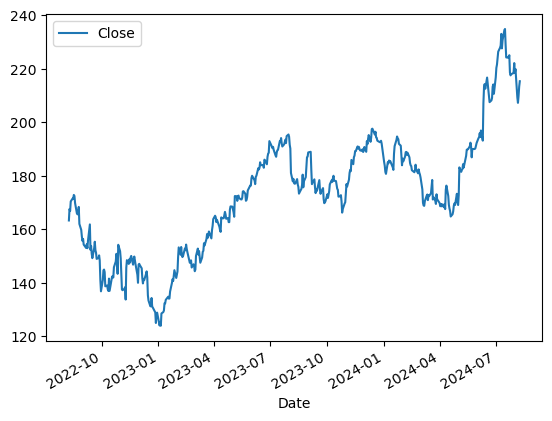

In [4]:
df.plot.line(y="Close")

In [5]:
df["Next Days Close"] = df['Close'].shift(-1)
df['change'] = (df['Next Days Close'] > df['Close']).astype(int)


In [6]:
df.tail()

,Open,High,Low,Close,Volume,Next Days Close,change
Date,,,,,,,
2024-08-05 00:00:00-04:00,199.089996,213.500000,196.000000,209.270004,119548600,207.229996,0
2024-08-06 00:00:00-04:00,205.300003,209.990005,201.070007,207.229996,69660500,209.820007,1
2024-08-07 00:00:00-04:00,206.899994,213.639999,206.389999,209.820007,63516400,213.309998,1
2024-08-08 00:00:00-04:00,213.110001,214.199997,208.830002,213.309998,44598400,215.300003,1
2024-08-09 00:00:00-04:00,212.080002,215.735001,211.979996,215.300003,13262848,NaN,0


In [7]:
# Preprocess data: Selecting 'Close' price and scaling

data = df[['Close']].values  # Extracting as numpy array

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)  # Now data_scaled is 2D


In [8]:
# Function to create sequences
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]   # X data
        X.append(a)
        Y.append(data[i + time_step, 0]) # Y label
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM [samples, time steps, features]

Time Step: This parameter defines the window of recent data points that the model should consider for predicting the next point in the sequence. In practical terms, if you set 'time_step = 10', the model will use the past 10 data points to make a prediction about the next data point.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [10]:
# Define and Tune the LSTM Model using Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [11]:
# Setup Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='model_tuning',
    project_name='StockPricePrediction'
)
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Reloading Tuner from model_tuning/StockPricePrediction/tuner0.json


In [12]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


/Users/keycaughey/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/keycaughey/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
# Further training if needed
best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0025 - va

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 47/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 48/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 49/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 50/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0027 - val_mean_squared_error: 0.0027


In [14]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

predictions = best_model.predict(X_test).flatten()
mse = mean_squared_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [15]:
# Display results
print(f'MSE: {mse}')
print(f'R-squared: {r_squared}')


MSE: 0.002704741902662897
R-squared: 0.9297297238440826


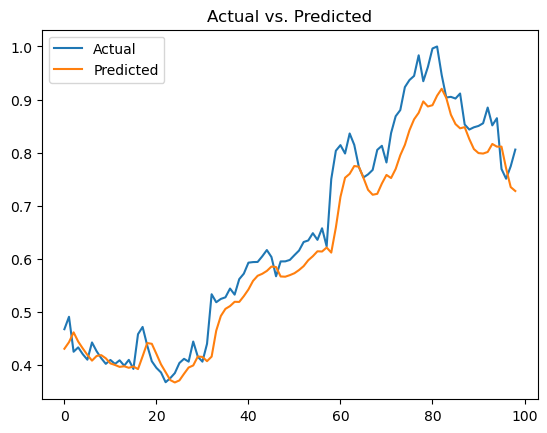

In [16]:
# Plotting actual vs predicted values
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
predictions_df.plot(title='Actual vs. Predicted')
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [18]:
# Make predictions
predictions = best_model.predict(X_test).flatten()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [19]:
# Assuming 'predictions' are the raw probabilities output by your model
predictions_binary = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

In [20]:
# Ensure y_test is binary and of integer type
y_test = y_test.astype(int)


In [21]:
precision = precision_score(y_test, predictions_binary)
accuracy = accuracy_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)
r_squared = r2_score(y_test, predictions)


print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f'R-squared: {r_squared}')


Precision: 0.0156
Accuracy: 0.3636
Recall: 1.0000
F1 Score: 0.0308
R-squared: -38.35442650959477


In [22]:
# Evaluate the model with regression metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)

# Display results
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared: {r_squared}')


MSE: 0.39350411161517074
RMSE: 0.6272990607478787
MAE: 0.6005889728213801
R-squared: -38.35442650959477


Mean Squared Error is the average of the squares of the differences between the actual and predicted values. It gives an idea of the magnitude of error made by the model.A lower MSE indicates a better fit



In [23]:
# Make prediction for the next day
latest_data = data_scaled[-time_step:].reshape(1, time_step, 1)
next_day_prediction = best_model.predict(latest_data)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [24]:
# Prepare the scaler and data (repeating the earlier steps)
scaler = MinMaxScaler(feature_range=(0, 1))
data = df[['Close']].values  # Extracting closing prices
data_scaled = scaler.fit_transform(data)  # Scaling the data

# Extract the last sequence from the scaled data
time_step = 10  # Make sure time_step is defined
latest_data = data_scaled[-time_step:].reshape(1, time_step, 1)  # Reshape for LSTM input

# Load your trained model (assuming best_model is already loaded)
next_day_prediction = best_model.predict(latest_data)[0][0]

# Interpret the prediction
if next_day_prediction > 0.5:
    print("The model predicts that the stock price will increase the next day.")
else:
    print("The model predicts that the stock price will decrease the next day.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The model predicts that the stock price will increase the next day.


In [25]:
next_day_price = scaler.inverse_transform([[next_day_prediction]])[0][0]
print(f"Next day predicted stock price: ${next_day_price:.2f}")


Next day predicted stock price: $208.54
